# Introduction

This notebook is contains an initial analysis of trades generated by Stockie (see https://github.com/frkornet/Stockie for more info). The trades are generated by the program trade.py. 

To be able to run this notebook, you need to have access to two CSV files: train_possible_trades.csv and test_possible_trades.csv. The files are expected to be in the data sub-directory of the current directory. 

The possible trades are generated by using a logistic regression model using a weight of evidence scoring model. The current model uses the following features (function `features` in trade.py):

- MACD_days
- PctDiff_days
- StdDev_days 

where days is 3, 5, 10, 15, 20, 30, 45 or 60. The days indicate on how many past day the feature is based. For example, StdDev_5 means that the feature is calculated using the past 5 days. This results in 24 different features used by the logistic regression model. All the features are derived from the trading day's stock close price.

The regression model uses smoothing to determine the points of local maxima and minima. The smoothing is implemented in function `smooth` in utils.py. The smoothing uses numpy savgol_filter() function the daily close price curve. The local minima and maxima are then determined in trade.py using the numpy argmin and argmax (see function `ticker_trades` for more details. 

The data is collected using the yfinance package. The yfinance package in turn retrieves the data from Yahoo Finance.

The intention is to build a Computation Data Analysis project around improving the performance in generating the possible trades. There are a number of areas that we want to investigate:

1) will performance improve if we add fundamental indicators or technical indicators,  

2) select the best features (for each ML model, see below),

3) will an ensemble of machine learning models improve performance, and

4) will a single stage approach (all trades are generated by an ensemble of models) or a two stage approach (one ensemble generates the possible trades and another ensemble determines which trades to keep/execute).


TODO (to be refined):
- scale the number of symbols down to a suitable subset to enable quick testing (2300+ to 200)
- determine time period to test over. Typically 15  years (split into 10 years for training and 5 years for test). With yfinance we have only 4 years for fundamental data. So, this suggests 3 years training and 1 year testing.
- determine which technical indicators to add to the model and implement them.
- determine which fundamental indicators to add to the model and implement them.
- refine trade.py to ensure that the model is only trained on positive trades in the training dataset.
- build an ensemble of different ML models (logistic regression, random forest trees, SVM) and determine performance
- build a two stage approach by two sets of ML models and ensembles






In [921]:
!pwd

/Users/frkornet/CDA/Project/stockie/notebook


In [922]:
# what is the current ../data directory
!ls ../data

actual_0.csv              actual_30.csv             open_buys.csv
actual_0_00.csv           actual_30_06.csv          origtrades
actual_0_01.csv           actual_30_07.csv          stocks202002.csv
actual_10.csv             actual_40.csv             techtrades
actual_10_02.csv          bak                       test_possible_trades.csv
actual_10_03.csv          exclude.csv               ticker_stats.csv
actual_20.csv             finaltrades               train_possible_trades.csv
actual_20_04.csv          full_possible_trades.csv  yfin
actual_20_05.csv          negtrades                 yfin_bak


In [923]:
# General imports and reading the possible trades files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv('../data/train_possible_trades.csv')
test_df = pd.read_csv('../data/test_possible_trades.csv')

print(f"Train row count: {len(train_df)}")
print(f"Test  row count: {len(test_df)}")

Train row count: 4403
Test  row count: 6508


In [924]:
def stats_table(df, days_cutoff, verbose=False):
    pos_df = df[['gain_pct', 'trading_days']].loc[df.gain_pct > 0].groupby(by='trading_days').count()
    pos_df.columns = ['pos_counts']
    loss_df = df[['gain_pct', 'trading_days']].loc[df.gain_pct < 0].groupby(by='trading_days').count()
    loss_df.columns = ['neg_counts']
    zero_df = df[['gain_pct', 'trading_days']].loc[df.gain_pct == 0].groupby(by='trading_days').count()
    zero_df.columns = ['zero_counts']
    temp = pd.concat([loss_df, pos_df, zero_df], join="outer").reset_index()
    cols = [ 'pos_counts', 'neg_counts', 'zero_counts' ]

    stats_cnt = np.zeros((3, 4))
    totals_col = np.zeros((4,))
    total_lt_xd = 0
    for i, num in enumerate(temp[cols].loc[temp.trading_days < days_cutoff].sum()):
        stats_cnt[0,i] = num
        stats_cnt[2,i] += num
    stats_cnt[0,3] = np.sum(stats_cnt[0,0:3])

    
    for i, num in enumerate(temp[cols].loc[temp.trading_days >= days_cutoff].sum()):
        stats_cnt[1,i] = num
        stats_cnt[2,i] += num
    stats_cnt[1,3] = np.sum(stats_cnt[1,0:3])  
    stats_cnt[2,3] = stats_cnt[0,3] + stats_cnt[1,3]
    
    stats_pct = (stats_cnt.copy() / stats_cnt[2,3]) * 100
    if verbose == False:
        return stats_cnt, stats_pct
    
    print('         \t pos     neg    zero    total')
    print('         \t======  ======  =====   ======')
    print(f'< {days_cutoff} days\t', end='')
    for i in range(4):
        print(f'{stats_cnt[0, i]:.0f}', end='\t')
        
    print(f'\n>= {days_cutoff} days\t', end='')
    for i in range(4):
        print(f'{stats_cnt[1, i]:.0f}', end='\t') 
    
    print('\n         \t------\t------\t-----\t------')
    print('         \t', end='')
    for i in range(4):
        print(f'{stats_cnt[2, i]:.0f}', end='\t')

    print('\n\n\n')
    print('         \t pos     neg    zero    total')
    print('         \t======  ======  =====   ======')
    print(f'< {days_cutoff} days\t', end='')
    for i in range(4):
        print(f'{stats_pct[0, i]:.2f}', end='\t')
        
    print(f'\n>= {days_cutoff} days\t', end='')
    for i in range(4):
        print(f'{stats_pct[1, i]:.2f}', end='\t') 
    
    print('\n         \t------\t------\t-----\t------')
    print('         \t', end='')
    for i in range(4):
        print(f'{stats_pct[2, i]:.2f}', end='\t')
    return stats_cnt, stats_pct

In [925]:
_, _ = stats_table(test_df, 55, verbose=True)

         	 pos     neg    zero    total
         	======  ======  =====   ======
< 55 days	4546	1046	24	5616	
>= 55 days	173	718	1	892	
         	------	------	-----	------
         	4719	1764	25	6508	



         	 pos     neg    zero    total
         	======  ======  =====   ======
< 55 days	69.85	16.07	0.37	86.29	
>= 55 days	2.66	11.03	0.02	13.71	
         	------	------	-----	------
         	72.51	27.11	0.38	100.00	

In [926]:
min(train_df.buy_date), max(train_df.buy_date)

('2011-03-30', '2018-05-01')

In [927]:
min(test_df.buy_date), max(test_df.buy_date)

('2017-11-28', '2021-02-04')

In [928]:
train_df

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
0,10.23,2011-04-12,0.52,5.28,10.77,2011-04-27,AAPL,10
1,12.19,2013-04-19,0.63,14.19,13.92,2013-05-20,AAPL,21
2,12.37,2013-06-27,0.52,25.71,15.55,2013-08-29,AAPL,44
3,22.16,2014-09-25,0.46,22.11,27.06,2014-11-26,AAPL,44
4,24.16,2015-01-06,0.50,21.48,29.35,2015-03-04,AAPL,39
...,...,...,...,...,...,...,...,...
4398,0.14,2014-05-29,3.06,100.00,0.28,2014-07-01,ZYXI,23
4399,0.10,2014-10-21,2.05,80.00,0.18,2014-12-02,ZYXI,29
4400,0.13,2014-12-23,2.35,38.46,0.18,2015-01-14,ZYXI,14
4401,0.13,2015-03-16,1.37,76.92,0.23,2015-05-14,ZYXI,42


In [929]:
test_df

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
0,39.78,2018-03-23,0.37,11.46,44.34,2018-05-04,AAPL,29
1,44.11,2018-06-25,0.29,5.94,46.73,2018-07-24,AAPL,20
2,52.57,2018-10-10,-0.29,-20.56,41.76,2019-02-04,AAPL,78
3,45.65,2019-05-13,0.17,5.30,48.07,2019-06-25,AAPL,30
4,47.53,2019-08-05,0.83,10.39,52.47,2019-08-21,AAPL,12
...,...,...,...,...,...,...,...,...
6503,9.15,2019-12-10,0.33,6.78,9.77,2020-01-09,ZYXI,20
6504,11.09,2020-03-11,0.46,9.56,12.15,2020-04-08,ZYXI,20
6505,21.30,2020-07-16,-0.46,-19.34,17.18,2020-09-22,ZYXI,47
6506,15.20,2020-10-12,-0.14,-6.25,14.25,2020-12-17,ZYXI,47


In [930]:
!ls ../data/yfin/CYBE.csv

../data/yfin/CYBE.csv


In [931]:
hist = pd.read_csv('../data/yfin/A.csv')
hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth
0,2011-02-14,29.54,29.81,29.35,29.40,4865300,0.0,0.0,28.141778
1,2011-02-15,29.40,29.54,27.99,28.00,10243200,0.0,0.0,28.172629
2,2011-02-16,28.16,28.62,28.03,28.60,5815400,0.0,0.0,28.203480
3,2011-02-17,28.47,28.88,28.24,28.83,3665200,0.0,0.0,28.234330
4,2011-02-18,28.78,29.07,28.65,28.83,6137600,0.0,0.0,28.265181
...,...,...,...,...,...,...,...,...,...
2512,2021-02-08,123.92,125.74,122.57,123.41,2065300,0.0,0.0,124.406604
2513,2021-02-09,123.41,123.49,122.36,123.24,1988300,0.0,0.0,124.465715
2514,2021-02-10,124.59,125.74,123.88,125.08,1112600,0.0,0.0,124.524825
2515,2021-02-11,125.70,127.26,125.11,126.96,1122200,0.0,0.0,124.583935


In [932]:
hist.index = hist.Date.values
hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth
2011-02-14,2011-02-14,29.54,29.81,29.35,29.40,4865300,0.0,0.0,28.141778
2011-02-15,2011-02-15,29.40,29.54,27.99,28.00,10243200,0.0,0.0,28.172629
2011-02-16,2011-02-16,28.16,28.62,28.03,28.60,5815400,0.0,0.0,28.203480
2011-02-17,2011-02-17,28.47,28.88,28.24,28.83,3665200,0.0,0.0,28.234330
2011-02-18,2011-02-18,28.78,29.07,28.65,28.83,6137600,0.0,0.0,28.265181
...,...,...,...,...,...,...,...,...,...
2021-02-08,2021-02-08,123.92,125.74,122.57,123.41,2065300,0.0,0.0,124.406604
2021-02-09,2021-02-09,123.41,123.49,122.36,123.24,1988300,0.0,0.0,124.465715
2021-02-10,2021-02-10,124.59,125.74,123.88,125.08,1112600,0.0,0.0,124.524825
2021-02-11,2021-02-11,125.70,127.26,125.11,126.96,1122200,0.0,0.0,124.583935


The training trades consist of only a limited number of trades in the 1 - 10 days. The test trades contain a much higher ratio of trades. Let's begine by analyzing why that is. We start by looking at the histograms. You can see that the histograms have a different underlying distribution. 

train: 1day_cnt=0 ratio %=0.00
test : 1day_cnt=168 ratio %=2.58


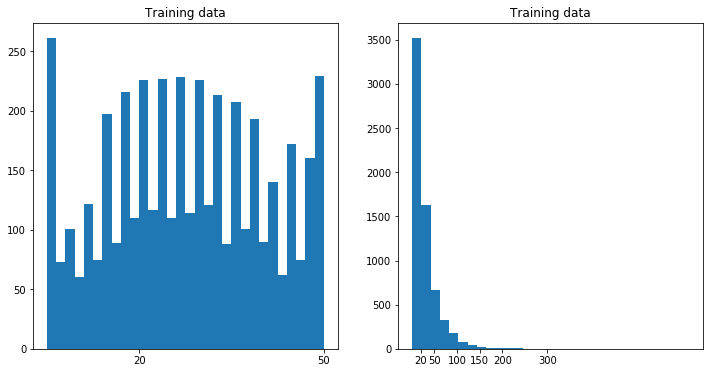

In [933]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.xticks([20, 50, 100, 150, 200, 300])
plt.title("Training data")
train_df.trading_days.hist(bins=30, grid=False)

plt.subplot(1,2,2)
plt.xticks([20, 50, 100, 150, 200, 300])
plt.title("Training data")
test_df.trading_days.hist(bins=30, grid=False)

train_1day_cnt  = train_df.loc[train_df.trading_days == 1].trading_days.count()
train_ratio_1day = (train_1day_cnt / len(train_df))*100
print(f"train: 1day_cnt={train_1day_cnt} ratio %={train_ratio_1day:.2f}")

test_1day_cnt  = test_df.loc[test_df.trading_days == 1].trading_days.count()
test_ratio_1day = ( test_1day_cnt / len(test_df) ) * 100
print(f"test : 1day_cnt={test_1day_cnt} ratio %={test_ratio_1day:.2f}")

Let's refine this by plotting a line chart of trading_days versus row counts, and it will become clear that there is quite a difference. In the training data set you see row count only going up to 600 - 700 around 40 - 50 trading days, while for testing trades it peaks at 1780 with 1 trading days, and then drops quickly down.

[0, 400, 0, 1750]

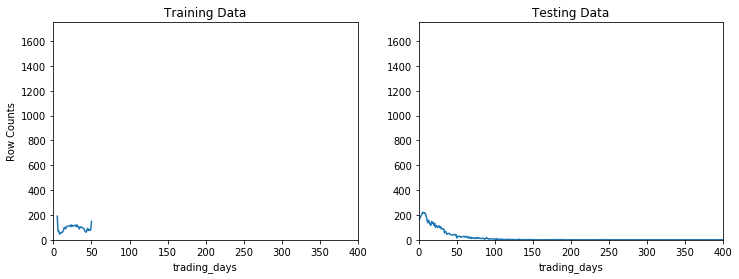

In [934]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Training Data")
train_df.groupby(by='trading_days').count()['ticker'].plot()
plt.ylabel("Row Counts")
plt.axis([0, 400, 0, 1750])

plt.subplot(1,2,2)
plt.title("Testing Data")
test_df.groupby(by='trading_days').count()['ticker'].plot()
plt.axis([0, 400, 0, 1750])

Taking this one step further, and let's split out the trades that earn money (gains), the trades that lose money (loss), and trades that make no money (zero). You can see that training split between gains and losses is almost 50/50. This is a bad thing and needs to be improved as the model may be learning the wrong signals. Furthermore, you can see that the losses in the test trades drop initially quicker than positive trades up to 40 trading days. After that the losses are slightly higher than gains.

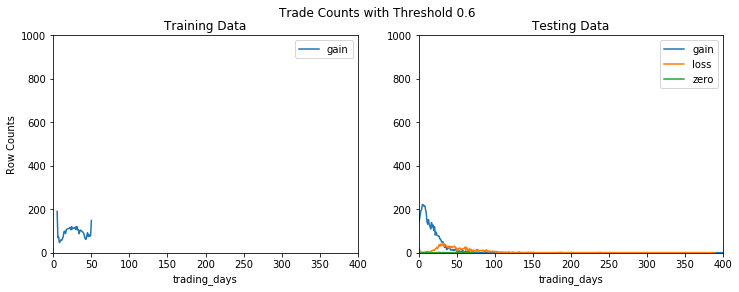

In [935]:
plt.figure(figsize=(12,4))

plt.suptitle("Trade Counts with Threshold 0.6")

plt.subplot(1,2,1)
train_df.loc[train_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
#train_df.loc[train_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
#train_df.loc[train_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Training Data")
plt.ylabel("Row Counts")

plt.subplot(1,2,2)
test_df.loc[test_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
test_df.loc[test_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
test_df.loc[test_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Testing Data")

plt.savefig("analysis_counts_06.png")

In [936]:
pos_df = test_df[['gain_pct', 'trading_days']].loc[test_df.gain_pct > 0].groupby(by='trading_days').count()
pos_df.columns = ['pos_counts']
loss_df = test_df[['gain_pct', 'trading_days']].loc[test_df.gain_pct < 0].groupby(by='trading_days').count()
loss_df.columns = ['neg_counts']
zero_df = test_df[['gain_pct', 'trading_days']].loc[test_df.gain_pct == 0].groupby(by='trading_days').count()
zero_df.columns = ['zero_counts']
temp = pd.concat([loss_df, pos_df, zero_df], join="outer").reset_index()
cols = [ 'pos_counts', 'neg_counts', 'zero_counts' ]
display(temp[cols].loc[temp.trading_days < 60].sum())
display(temp[cols].loc[temp.trading_days >= 60].sum())

pos_counts     4581.0
neg_counts     1134.0
zero_counts      24.0
dtype: float64

pos_counts     138.0
neg_counts     630.0
zero_counts      1.0
dtype: float64

In [937]:
# Function to calculate for each ticker symbol, the overall performance. The aim here is 
# to calculate the performance if you traded each possible trade for that ticker. 
# The overall daily return is calculated for the set of possible trades. This in turn
# is used in the cells below to determine a correlation between training and testing trades.
# The function prints each trade if verbose is set to True. 

def ticker_stats(df, ticker, verbose=False):
    if ticker != '*':
        tdf = df.loc[(df.ticker==ticker)]
    gains      = losses    = perf = 1.0
    gains_cnt  = loss_cnt  = 0
    gains_days = loss_days = days = 0
    gl = tdf.sort_values(by='buy_date').gain_pct
    dl = tdf.sort_values(by='buy_date').trading_days
    #print("gl=", gl)
    if verbose == True:
        print("Perf b4\t\tGains\t\tPerf\t\tGain Cnt   Gains\tLoss Cnt\tLosses  Days")
        print("=======\t\t=====\t\t====\t\t========   =====\t========\t======  ====")
    for g, d in zip(gl,dl):
        perfs = perf
        perf  = perf * (1.0 + g/100.0)
        days += d
        if g > 0:
            gains_cnt += 1
            gains_days += d
            gains = gains * (1.0 + g/100.0)
        else:
            loss_cnt  += 1
            loss_days += d
            losses = losses * (1.0 + g/100.0)
        
        if verbose == True:
            print(f"{perfs:.4f}\t\t{g:.3f}\t\t{perf:.4f}\t\t{gains_cnt:03d}\t   {gains:.4f}\t{loss_cnt:03d}\t\t{losses:.4f}  {d}")
        
    return perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses

In [938]:
# AAPL stats using train_df:
perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = \
    ticker_stats(train_df, 'AAPL', verbose=True)
train_dret = (perf ** (1/days) - 1.0) * 100.0
print(f"\ntrain_dret={train_dret}")

Perf b4		Gains		Perf		Gain Cnt   Gains	Loss Cnt	Losses  Days
=======		=====		====		========   =====	========	======  ====
1.0000		5.280		1.0528		001	   1.0528	000		1.0000  10
1.0528		14.190		1.2022		002	   1.2022	000		1.0000  21
1.2022		25.710		1.5113		003	   1.5113	000		1.0000  44
1.5113		22.110		1.8454		004	   1.8454	000		1.0000  44
1.8454		21.480		2.2418		005	   2.2418	000		1.0000  39
2.2418		17.880		2.6427		006	   2.6427	000		1.0000  36
2.6427		4.900		2.7721		007	   2.7721	000		1.0000  15
2.7721		14.730		3.1805		008	   3.1805	000		1.0000  42

train_dret=0.4620328233166493


In [939]:
# AAPL stats using test_df:
perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = \
    ticker_stats(test_df, 'AAPL', verbose=True)
test_dret = (perf ** (1/days) - 1.0) * 100.0
print(f"\ntest_dret={test_dret}")

Perf b4		Gains		Perf		Gain Cnt   Gains	Loss Cnt	Losses  Days
=======		=====		====		========   =====	========	======  ====
1.0000		11.460		1.1146		001	   1.1146	000		1.0000  29
1.1146		5.940		1.1808		002	   1.1808	000		1.0000  20
1.1808		-20.560		0.9380		002	   1.1808	001		0.7944  78
0.9380		5.300		0.9877		003	   1.2434	001		0.7944  30
0.9877		10.390		1.0904		004	   1.3726	001		0.7944  12
1.0904		-10.130		0.9799		004	   1.3726	002		0.7139  33
0.9799		13.340		1.1106		005	   1.5557	002		0.7139  17
1.1106		7.050		1.1889		006	   1.6654	002		0.7139  6

test_dret=0.07694715657242668


In [940]:
# Determine the unique set of ticker symbols. Determine the common symbols, the symbols missing in 
# testing, and the symbols missing in training.
#
train_tickers = set(train_df.ticker.unique())
test_tickers  = set(test_df.ticker.unique())
ctickers = train_tickers & test_tickers
print("Common tickers   :", len(ctickers))

missing_in_test_tickers = train_tickers - test_tickers
print("Missing in test  :", len(missing_in_test_tickers))

missing_in_train_tickers = test_tickers - train_tickers
print("Missing in train :", len(missing_in_train_tickers))

Common tickers   : 541
Missing in test  : 1
Missing in train : 0


In [941]:
# Function that goes through the common train and test symbols, and for each symbol determine the
# overall daily return for train and test. These are then added to two separate lists. The function
# leverages the ticker_stats() function defined above. The function takes a while to run, as it has 
# over 2380 symbols to process. Can probably be done quicker using vectorized operations. Does work
# for now.

def calc_daily_returns_n_corr(train_df, test_df):
    train_daily_rets_l = []
    test_daily_rets_l  = []
    for i, t in enumerate(ctickers):

        perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = ticker_stats(train_df, t)
        if days == 0.0:
            continue
        train_dret = (perf ** (1/days) - 1.0) * 100.0

        perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = ticker_stats(test_df, t)
        if days == 0.0:
            continue
        test_dret = (perf ** (1/days) - 1.0) * 100.0

        train_daily_rets_l.append(train_dret.real)
        test_daily_rets_l.append(test_dret.real)


    return train_daily_rets_l, test_daily_rets_l

The correlation between the train and test trades is calculated below. The correlation is 0.15. This is not much. It can be improved by eliminating the losses from training trades. Doing so, improves the correlation to 0.23. A bit better but not much. It should be noted that the inherent random walk of stock prices prevents us from ever getting a correlation of one. As a result, I would assume a correlation of 0.4 - 0.5 to be excellent.

The scatter plots for both sets of daily return is plotted below as well. They are side by side, so you can more easily compare them.

The correlation can be used as a measure to determine whether the different solutions are better or not. 

In [942]:
train_daily_rets, test_daily_rets = calc_daily_returns_n_corr(train_df, test_df)
corr = np.corrcoef(train_daily_rets, test_daily_rets )
print(corr)

[[ 1.         -0.06413563]
 [-0.06413563  1.        ]]


[[ 1.         -0.06413563]
 [-0.06413563  1.        ]]


Text(0.5, 1.0, 'Gains only')

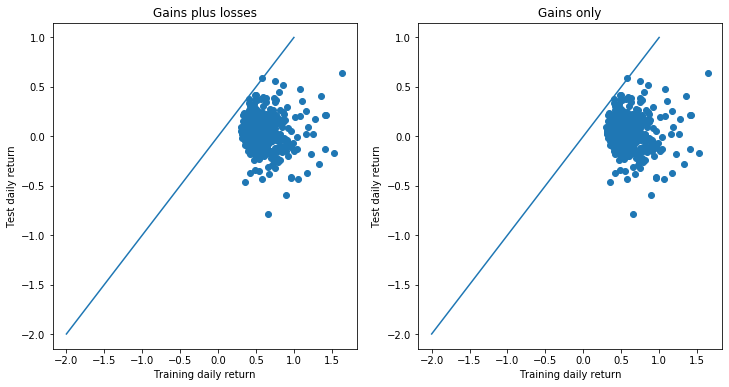

In [943]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(train_daily_rets, test_daily_rets)

x = [i/10 for i in range(-20, 11)]
y = [i/10 for i in range(-20, 11)]
plt.plot(x, y)

plt.xlabel("Training daily return")
plt.ylabel("Test daily return")
plt.title("Gains plus losses")

plt.subplot(1,2,2)
pos_xlist = []
pos_ylist = []
for xv, yv in zip(train_daily_rets, test_daily_rets):
    if xv > 0:
        pos_xlist.append(xv)
        pos_ylist.append(yv)

pcorr = np.corrcoef(pos_xlist, pos_ylist)
print(pcorr)

plt.scatter(pos_xlist, pos_ylist)
plt.plot(x, y)
plt.xlabel("Training daily return")
plt.ylabel("Test daily return")
plt.title("Gains only")


In [944]:
# Function to calculate the overall daily return of all trades
# for each specific number of trading days.
def plot_trading_days_vs_daily_return(df):
    days = list(np.sort(df.trading_days.unique()))

    gains = df[['gain_pct', 'trading_days']].copy()
    gains.gain_pct = 1+df.gain_pct/100.0

    td_df = gains[['trading_days', 'gain_pct']].groupby(by=df.trading_days).agg(['count', 'prod'])
    td = (td_df.index * td_df[('trading_days', 'count')])
    inv_td = 1/td

    drets = (td_df[('gain_pct',  'prod')] ** inv_td) - 1.0
    drets *= 100

    plt.plot(days, drets)


Using the function `plot_trading_days_vs_daily_return`, we can now plot the daily returns against the number of trading days for both train and test trades. For training data, you can see that the line moves up and down around the zero daily return line (red in the bottom two figures). This is due to the fact that losses and gains are about 50/50 split. Removing the losses should push the daily return line above the zero line.

For testing data, the pattern is entirely different, it starts off well above the zero daily return line (red) but drops below the zero line around 50 trading days and stays below the zero line after that. This seems to suggest that the losses outweigh the gains. It is unclear why the overall daily returns are above the zero line for the first 50 days. Note that if you are able to predict the number of trading days for the trade, you can reduce the chance of selecting losing trades. Before going there, the losses need to be removed from the training trades.

For more easy understanding the row counts for gains, losses, and no gains (zero) is shown in the top row of the four charts.

To put daily return in context. There are 200 trading days per year. The table shows what the annual return would be if the daily return is 0.1 - 0.4 percent. It is important to understand that the daily return compounds (i.e. it is an exponential function and not a linear one). 

| Daily Return | Annual Gain |
|--------------|-------------|
| 0.1%         | 22.1%       |
| 0.2%         | 49.1%       |
| 0.3%         | 82.0%       |
| 0.4%.        | 122.0%      |


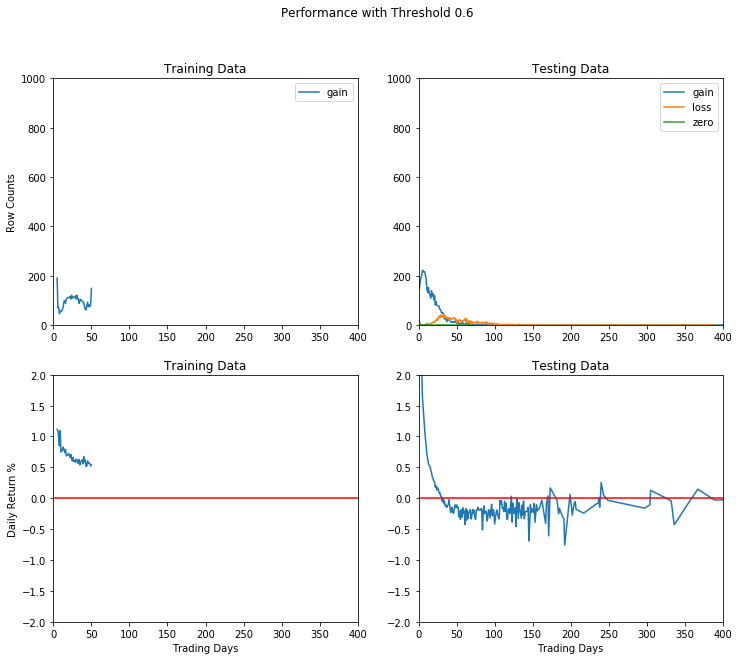

In [945]:
plt.figure(figsize=(12,10))

plt.suptitle("Performance with Threshold 0.6")
plt.subplot(2,2,1)
train_df.loc[train_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
#train_df.loc[train_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
#train_df.loc[train_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Training Data")
plt.ylabel("Row Counts")
plt.xlabel("")

plt.subplot(2,2,2)
test_df.loc[test_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
test_df.loc[test_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
test_df.loc[test_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Testing Data")
plt.xlabel("")

hx=[1, 400]
hy=[0, 0]

plt.subplot(2,2,3)
plt.title("Training Data")
plt.axis([0, 400, -2.0, 2.0])
plot_trading_days_vs_daily_return(train_df)
plt.xlabel("Trading Days")
plt.ylabel("Daily Return %")
plt.plot(hx, hy, color='red')

plt.subplot(2,2,4)
plt.title("Testing Data")
plt.axis([0, 400, -2.0, 2.0])
plot_trading_days_vs_daily_return(test_df)
plt.xlabel("Trading Days")
plt.plot(hx, hy, color='red')

plt.savefig("analysis_summary_06.png")

In [946]:
len(test_df)

6508

In [947]:
test_df[['trading_days', 'gain_pct']].groupby(by='trading_days').count()[0:25]

,gain_pct
trading_days,
1,168
2,178
3,195
4,202
5,222
6,221
7,215
8,219
9,207


In [948]:
test_df[['trading_days', 'gain_pct']].loc[test_df.gain_pct > 0].groupby(by='trading_days').count()

,gain_pct
trading_days,
1,148
2,172
3,193
4,200
5,222
...,...
240,1
243,1
305,1


In [949]:
ls -l ../data/*possible*.csv

-rw-r--r--  1 frkornet  staff  561781 Apr 26 09:47 ../data/full_possible_trades.csv
-rw-r--r--  1 frkornet  staff  335586 Apr 26 09:47 ../data/test_possible_trades.csv
-rw-r--r--  1 frkornet  staff  226277 Apr 26 09:47 ../data/train_possible_trades.csv


In [950]:
actual_trades_df = pd.read_csv('../data/actual_0_00.csv')
actual_trades_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret
0,2017-11-29,OTEX,SELL,2000.000000,1980.000000,64.071145,30.903147,-10.049751,-0.505000,2,0,-20.000000,-1.00,-0.501256
1,2017-12-11,VSH,SELL,1996.000000,1976.040000,101.123709,19.540818,-35.310579,-1.755566,6,0,-19.960000,-1.00,-0.167365
2,2018-02-07,HAL,SELL,1993.383282,1973.449450,42.848692,46.056235,-33.583284,-1.673280,3,0,-19.933833,-1.00,-0.334451
3,2018-02-07,VSH,SELL,1991.399816,1971.485818,108.813419,18.118039,-10.006536,-0.505000,2,0,-19.913998,-1.00,-0.501256
4,2018-02-09,PTEN,SELL,1985.413716,1965.559579,111.172540,17.680261,-9.976457,-0.505000,2,0,-19.854137,-1.00,-0.501256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,2021-02-11,COG,SELL,62364.353185,61740.709654,3533.831593,17.471322,-1196.831016,-1.901617,5,0,-623.643532,-1.00,-0.200805
1184,2021-02-11,AKAM,SELL,62059.905558,61439.306502,587.546620,104.569245,-311.843307,-0.505000,2,0,-620.599056,-1.00,-0.501256
1185,2021-02-12,SPSC,SELL,59207.571105,62368.480469,569.317801,102.957426,-438.659366,-0.698423,8,0,3160.909364,5.34,0.652407
1186,2021-02-12,IVC,SELL,61809.276648,61191.183881,6379.851432,9.591318,-310.583927,-0.505000,2,0,-618.092766,-1.00,-0.501256


In [951]:
min(actual_trades_df.date), max(actual_trades_df.date)

('2017-11-29', '2021-02-12')

In [952]:
actual_trades_in_2018 = actual_trades_df.loc[(actual_trades_df.date >= '2018-01-01') & (actual_trades_df.date <= '2018-12-31')]
actual_trades_in_2018

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret
2,2018-02-07,HAL,SELL,1993.383282,1973.449450,42.848692,46.056235,-33.583284,-1.673280,3,0,-19.933833,-1.00,-0.334451
3,2018-02-07,VSH,SELL,1991.399816,1971.485818,108.813419,18.118039,-10.006536,-0.505000,2,0,-19.913998,-1.00,-0.501256
4,2018-02-09,PTEN,SELL,1985.413716,1965.559579,111.172540,17.680261,-9.976457,-0.505000,2,0,-19.854137,-1.00,-0.501256
5,2018-02-28,WYY,SELL,1981.442889,1961.727039,428.605427,4.576770,-9.857925,-0.500000,2,0,-19.715850,-1.00,-0.501256
6,2018-02-28,AUMN,SELL,1981.442889,1961.628460,4928.962410,0.397980,-9.956504,-0.505000,2,0,-19.814429,-1.00,-0.501256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2018-12-21,AUMN,SELL,3626.341823,3590.078405,16401.365097,0.218889,-18.221917,-0.505000,2,0,-36.263418,-1.00,-0.501256
301,2018-12-21,NHTC,SELL,3626.341823,3590.078405,232.045037,15.471473,-18.221917,-0.505000,2,0,-36.263418,-1.00,-0.501256
302,2018-12-24,GLUU,SELL,3610.481520,3574.376705,503.153911,7.103943,-18.142221,-0.505000,2,0,-36.104815,-1.00,-0.501256
303,2018-12-26,BFIN,SELL,3592.104010,3703.747354,274.307970,12.964198,129.514508,3.623561,2,0,111.643344,3.11,1.543094


In [953]:
actual_trades_in_2019 = actual_trades_df.loc[(actual_trades_df.date >= '2019-01-01') & (actual_trades_df.date <= '2019-12-31')]
actual_trades_in_2019

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret
305,2019-01-02,CRMD,SELL,3610.481520,4358.450263,630.266478,5.671215,293.231479,7.213178,7,0,747.968743,20.72,2.726560
306,2019-01-04,ACRX,SELL,3937.662433,4108.399958,1506.950797,2.586870,190.327886,4.857692,2,0,170.737525,4.34,2.146953
307,2019-01-08,AMRB,SELL,3884.859173,4141.110529,311.988016,12.327431,253.739853,6.527287,3,0,256.251357,6.60,2.153300
308,2019-01-10,CRY,SELL,3937.662433,4172.429076,151.276914,25.769205,3.237326,0.077649,6,0,234.766643,5.96,0.969528
309,2019-01-11,KOSS,SELL,4035.186159,4035.800717,2048.525820,1.950102,-40.765664,-1.000000,4,0,0.614558,0.02,0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,2019-12-27,SPPI,SELL,7688.657256,7699.149241,2185.830066,3.482325,48.744010,0.637143,2,0,10.491984,0.14,0.069976
695,2019-12-30,TWIN,SELL,8204.412901,9104.279167,850.374472,9.551520,243.377174,2.746641,14,0,899.866266,10.97,0.746269
696,2019-12-30,TSBK,SELL,8330.516898,8535.686656,304.745277,27.062640,-88.604689,-1.027385,10,0,205.169758,2.46,0.243318
697,2019-12-30,NBIX,SELL,8502.734975,8417.707626,78.373625,107.404853,-81.128262,-0.954581,3,0,-85.027350,-1.00,-0.334451


In [954]:
actual_trades_in_2020 = actual_trades_df.loc[(actual_trades_df.date >= '2020-01-01') & (actual_trades_df.date <= '2020-12-31')]
actual_trades_in_2020

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret
699,2020-01-03,GERN,SELL,8666.491537,8579.826621,6483.740348,1.323283,-43.548042,-0.505000,2,0,-86.664915,-1.00,-0.501256
700,2020-01-06,VNRX,SELL,7699.149241,8550.502278,1665.401090,4.576770,556.577044,6.962500,6,0,851.353037,11.06,1.763713
701,2020-01-07,IRIX,SELL,8969.605188,9079.466492,4002.233312,2.218739,154.486206,1.730942,2,0,109.861304,1.22,0.608151
702,2020-01-07,CLW,SELL,8227.344909,8145.071459,402.478508,20.237283,-41.341385,-0.505000,2,0,-82.273449,-1.00,-0.501256
703,2020-01-08,NPTN,SELL,8204.412901,9779.186370,1067.136592,7.611367,270.999337,2.850168,20,0,1574.773468,19.19,0.881607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,2020-12-30,ZYXI,SELL,47738.970318,49889.731004,3566.175901,13.252734,2388.268001,5.027778,2,0,2150.760686,4.51,2.230133
1141,2020-12-31,MOV,SELL,47999.695110,47519.698159,2884.111755,16.476372,-241.192498,-0.505000,2,0,-479.996951,-1.00,-0.501256
1142,2020-12-31,ZUMZ,SELL,48156.286714,48696.597109,1330.649908,35.828149,-31.802533,-0.065265,5,0,540.310395,1.12,0.223003
1143,2020-12-31,GORO,SELL,47999.695110,47519.698159,15555.266629,3.054894,-241.192498,-0.505000,2,0,-479.996951,-1.00,-0.501256


In [955]:
actual_trades_in_2021 = actual_trades_df.loc[(actual_trades_df.date >= '2021-01-01') & (actual_trades_df.date <= '2021-12-31')]
actual_trades_in_2021

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret
1145,2021-01-05,NNBR,SELL,47676.786669,47200.018803,7854.236544,6.009498,-239.569923,-0.505000,2,0,-476.767867,-1.00,-0.501256
1146,2021-01-05,HURC,SELL,47176.846606,46705.078140,1623.172058,28.773954,-237.057786,-0.505000,2,0,-471.768466,-1.00,-0.501256
1147,2021-01-07,ENSV,SELL,47962.574971,53833.642293,25520.831655,1.860556,-270.520816,-0.500000,5,0,5871.067322,12.24,2.336258
1148,2021-01-07,SNCR,SELL,51947.390317,52258.118116,11882.516227,4.328032,569.172527,1.101149,2,0,310.727799,0.60,0.299551
1149,2021-01-11,AXAS,SELL,48253.720296,54240.750138,20966.660278,2.278436,2453.099252,4.736842,7,0,5987.029842,12.41,1.685224
1150,2021-01-11,URBN,SELL,50384.833478,55031.268446,1930.464485,25.838852,3487.866708,6.766854,3,0,4646.434968,9.22,2.983439
1151,2021-01-11,NFLX,SELL,50384.833478,49880.985143,98.516698,506.320105,-401.937736,-0.799352,3,0,-503.848335,-1.00,-0.334451
1152,2021-01-12,SWN,SELL,47709.296196,58404.915946,16037.816390,2.945052,5800.878188,11.027439,10,0,10695.619750,22.42,2.043474
1153,2021-01-12,SNCR,SELL,51899.438160,51380.443778,12037.583217,4.268336,-260.788222,-0.505000,2,0,-518.994382,-1.00,-0.501256
1154,2021-01-15,O,SELL,53540.600973,53774.749432,928.607806,57.080281,481.947451,0.904339,4,0,234.148458,0.44,0.109819


In [956]:
len(actual_trades_in_2021)

43

In [957]:
len(actual_trades_in_2018.ticker.unique())

134

In [958]:
len(actual_trades_in_2019.ticker.unique())

170

In [959]:
len(actual_trades_in_2020.ticker.unique())

182

In [960]:
len(actual_trades_in_2020.ticker.unique())

182

In [961]:
possible_trades_df = pd.read_csv('../data/test_possible_trades.csv')
possible_trades_df

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
0,39.78,2018-03-23,0.37,11.46,44.34,2018-05-04,AAPL,29
1,44.11,2018-06-25,0.29,5.94,46.73,2018-07-24,AAPL,20
2,52.57,2018-10-10,-0.29,-20.56,41.76,2019-02-04,AAPL,78
3,45.65,2019-05-13,0.17,5.30,48.07,2019-06-25,AAPL,30
4,47.53,2019-08-05,0.83,10.39,52.47,2019-08-21,AAPL,12
...,...,...,...,...,...,...,...,...
6503,9.15,2019-12-10,0.33,6.78,9.77,2020-01-09,ZYXI,20
6504,11.09,2020-03-11,0.46,9.56,12.15,2020-04-08,ZYXI,20
6505,21.30,2020-07-16,-0.46,-19.34,17.18,2020-09-22,ZYXI,47
6506,15.20,2020-10-12,-0.14,-6.25,14.25,2020-12-17,ZYXI,47


In [962]:
possible_trades_in_2018 = possible_trades_df.loc[(possible_trades_df.sell_date >= '2018-01-01') & (possible_trades_df.sell_date <= '2018-12-31')]
possible_trades_in_2018

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
0,39.78,2018-03-23,0.37,11.46,44.34,2018-05-04,AAPL,29
1,44.11,2018-06-25,0.29,5.94,46.73,2018-07-24,AAPL,20
8,49.79,2018-03-23,0.19,6.05,52.80,2018-05-08,ABCB,31
15,84.49,2018-03-20,0.20,3.99,87.86,2018-04-18,ABC,20
16,80.87,2018-05-03,0.23,6.65,86.25,2018-06-13,ABC,28
...,...,...,...,...,...,...,...,...
6494,3.02,2018-05-10,0.61,10.26,3.33,2018-06-04,ZYXI,16
6495,2.98,2018-06-12,3.43,14.43,3.41,2018-06-18,ZYXI,4
6496,3.02,2018-06-22,0.02,0.66,3.04,2018-08-17,ZYXI,39
6497,2.90,2018-09-28,0.77,7.93,3.13,2018-10-12,ZYXI,10


In [963]:
possible_trades_in_2019 = possible_trades_df.loc[(possible_trades_df.sell_date >= '2019-01-01') & (possible_trades_df.sell_date <= '2019-12-31')]
possible_trades_in_2019

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
2,52.57,2018-10-10,-0.29,-20.56,41.76,2019-02-04,AAPL,78
3,45.65,2019-05-13,0.17,5.30,48.07,2019-06-25,AAPL,30
4,47.53,2019-08-05,0.83,10.39,52.47,2019-08-21,AAPL,12
9,51.70,2018-06-27,-0.24,-29.90,36.24,2019-01-28,ABCB,146
10,36.53,2019-03-15,-0.02,-0.60,36.31,2019-05-03,ABCB,34
...,...,...,...,...,...,...,...,...
6481,31.63,2019-11-06,0.55,12.14,35.47,2019-12-06,ZUMZ,21
6499,2.92,2018-11-19,0.08,2.74,3.00,2019-01-09,ZYXI,33
6500,7.70,2019-07-15,0.77,17.40,9.04,2019-08-13,ZYXI,21
6501,8.51,2019-08-27,1.87,11.75,9.51,2019-09-05,ZYXI,6


In [964]:
possible_trades_in_2020 = possible_trades_df.loc[(possible_trades_df.sell_date >= '2020-01-01') & (possible_trades_df.sell_date <= '2020-12-31')]
possible_trades_in_2020

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
5,73.97,2020-02-24,-0.32,-10.13,66.48,2020-04-09,AAPL,33
6,106.50,2020-09-18,0.74,13.34,120.71,2020-10-13,AAPL,17
7,110.84,2020-10-28,1.14,7.05,118.65,2020-11-05,AAPL,6
12,40.59,2020-01-24,-0.51,-35.30,26.26,2020-05-27,ABCB,85
13,20.91,2020-06-26,0.69,22.19,25.55,2020-08-07,ABCB,29
...,...,...,...,...,...,...,...,...
6503,9.15,2019-12-10,0.33,6.78,9.77,2020-01-09,ZYXI,20
6504,11.09,2020-03-11,0.46,9.56,12.15,2020-04-08,ZYXI,20
6505,21.30,2020-07-16,-0.46,-19.34,17.18,2020-09-22,ZYXI,47
6506,15.20,2020-10-12,-0.14,-6.25,14.25,2020-12-17,ZYXI,47


In [965]:
possible_trades_in_2021 = possible_trades_df.loc[(possible_trades_df.sell_date >= '2021-01-01') & (possible_trades_df.sell_date <= '2021-12-31')]
possible_trades_in_2021

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
54,38.01,2020-12-23,0.99,8.16,41.11,2021-01-06,ABM,8
88,4.32,2020-11-19,0.97,41.67,6.12,2021-01-13,ACOR,36
107,1.55,2020-11-13,0.88,40.65,2.18,2021-01-12,ACRX,39
146,64.52,2021-01-04,0.09,2.17,65.92,2021-02-05,ADC,23
167,70.83,2020-12-29,2.13,11.13,78.71,2021-01-06,ADS,5
...,...,...,...,...,...,...,...,...
6406,589.53,2020-11-20,0.26,8.43,639.24,2021-01-07,Y,31
6440,13.93,2020-12-18,0.76,7.82,15.02,2021-01-05,ZEUS,10
6441,14.09,2021-01-28,1.64,10.22,15.53,2021-02-05,ZEUS,6
6461,2.69,2020-12-28,1.32,8.18,2.91,2021-01-06,ZIOP,6


In [966]:
len(possible_trades_in_2018.ticker.unique())

514

In [967]:
len(possible_trades_in_2019.ticker.unique())

539

In [968]:
len(possible_trades_in_2020.ticker.unique())

535

In [969]:
len(possible_trades_in_2021.ticker.unique())

208

In [970]:
sum(possible_trades_in_2018.sell_close - possible_trades_in_2018.buy_close)

2802.052400000004

In [971]:
sum(possible_trades_in_2019.sell_close - possible_trades_in_2019.buy_close)

2462.218299999996

In [972]:
sum(possible_trades_in_2020.sell_close - possible_trades_in_2020.buy_close)

2541.385300000001

In [973]:
sum(possible_trades_in_2021.sell_close - possible_trades_in_2021.buy_close)

1703.1362999999997

In [974]:
ls -l ../data/yfin/SPY.csv

ls: ../data/yfin/SPY.csv: No such file or directory


In [975]:
actual_trades_df.gain_pct

0      -1.00
1      -1.00
2      -1.00
3      -1.00
4      -1.00
        ... 
1183   -1.00
1184   -1.00
1185    5.34
1186   -1.00
1187   -1.00
Name: gain_pct, Length: 1188, dtype: float64

In [976]:
actual_trades_df.loc[actual_trades_df.gain_pct == -10.0]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret


In [977]:
len(actual_trades_df)

1188

In [978]:
stop_loss_val = -10.0

In [979]:
len(actual_trades_df.loc[actual_trades_df.gain_pct == stop_loss_val])/len(actual_trades_df)

0.0

In [980]:
sum(actual_trades_df.gain.loc[(actual_trades_df.gain < 0.0)])

-108271.900680313

In [981]:
sum(actual_trades_df.gain.loc[(actual_trades_df.gain < 0.0) & (actual_trades_df.gain_pct == stop_loss_val)])

0

In [982]:
stop_loss = actual_trades_df.loc[(actual_trades_df.gain_pct == stop_loss_val)]
stop_loss

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret


In [983]:
stop_loss_in_2018 = stop_loss.loc[(stop_loss.date >= '2018-01-01') & (stop_loss.date <= '2018-12-31')]
stop_loss_in_2018

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret


In [984]:
len(stop_loss_in_2018)

0

In [985]:
sum(stop_loss_in_2018.gain)

0

In [986]:
stop_loss_in_2019 = stop_loss.loc[(stop_loss.date >= '2019-01-01') & (stop_loss.date <= '2019-12-31')]
stop_loss_in_2019

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret


In [987]:
len(stop_loss_in_2019)

0

In [988]:
sum(stop_loss_in_2019.gain)

0

In [989]:
stop_loss_in_2020 = stop_loss.loc[(stop_loss.date >= '2020-01-01') & (stop_loss.date <= '2020-12-31')]
stop_loss_in_2020

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret


In [990]:
len(stop_loss_in_2020)

0

In [991]:
sum(stop_loss_in_2020.gain)

0

In [992]:
stop_loss_in_2021 = stop_loss.loc[(stop_loss.date >= '2021-01-01') & (stop_loss.date <= '2021-12-31')]
stop_loss_in_2021

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_ret


In [993]:
len(stop_loss_in_2021)

0

In [994]:
sum(stop_loss_in_2021.gain)

0

In [1014]:
asset = yf.Ticker('^VIX')
hist = asset.history(start='2017-11-24', end='2021-03-01')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-24,9.82,9.96,8.56,9.67,0,0,0
2017-11-27,10.07,10.26,9.79,9.87,0,0,0
2017-11-28,9.72,10.31,9.53,10.03,0,0,0
2017-11-29,9.91,10.93,9.81,10.70,0,0,0
2017-11-30,10.49,12.05,10.25,11.28,0,0,0
...,...,...,...,...,...,...,...
2021-02-22,24.46,25.09,21.96,23.45,0,0,0
2021-02-23,22.82,27.01,22.50,23.11,0,0,0
2021-02-24,23.76,25.04,21.31,21.34,0,0,0


In [1015]:
ls '../../docs/Final Report' 

Final Report.docx                  final_analysis_summary.png
Final report.md                    final_perf_20_3.png
Final report.pdf                   orig_analysis_summary.png
Kornet_Frank_project_proposal.pdf  orig_perf_00_4.png
SPY.png                            proposal_pics.pptx
SPY_normed.png                     schedule.png
VIX.png                            smooth_vs_close.png
VIX_normed.png                     state transition diagram.png
diagram_stockie.png


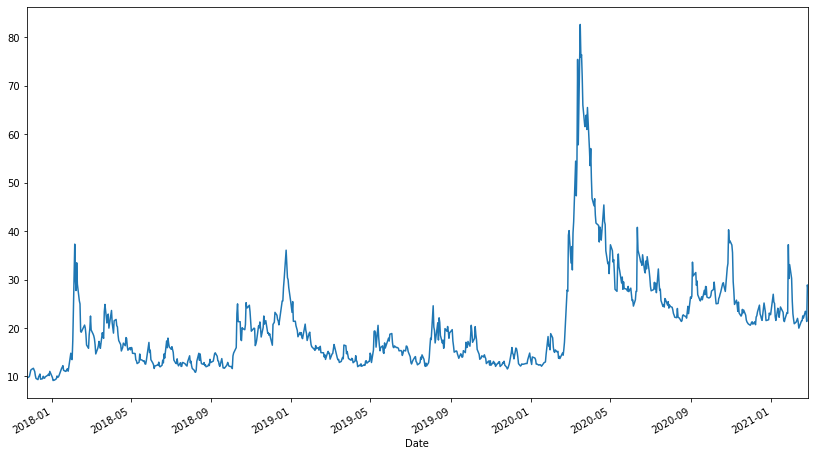

In [1016]:
hist.Close.plot(figsize=(14,8))
plt.savefig('../../docs/Final Report/VIX.png')

In [1017]:
hist.norm = (hist.Close / 9.67) * 100

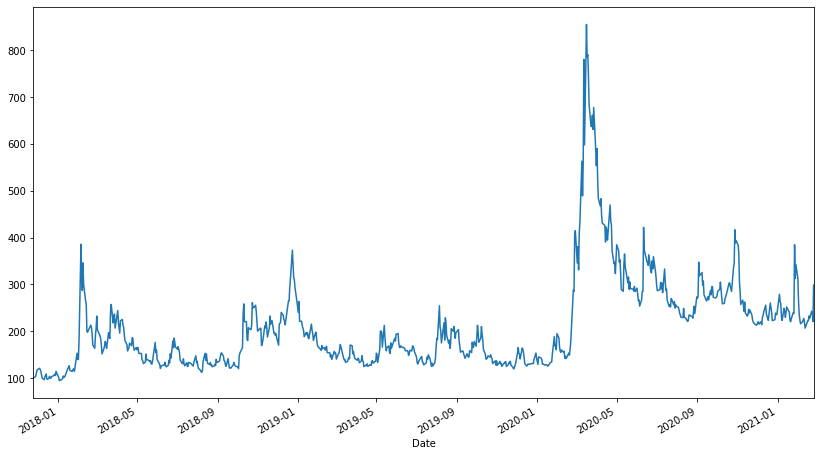

In [1018]:
hist.norm.plot(figsize=(14,8))
plt.savefig('../../docs/Final Report/VIX_normed.png')

In [1000]:
len(actual_trades_df)

1188

In [1001]:
actual_trades_df.days_in_trade.agg(["sum", "min", "max", "mean", "std", "median"])

sum       4330.000000
min          2.000000
max         80.000000
mean         3.644781
std          3.928392
median       2.000000
Name: days_in_trade, dtype: float64

In [1002]:
actual_trades_df.days_in_trade.value_counts() #/len(actual_trades_df)

2     644
3     228
4      99
5      53
6      40
7      29
9      18
11     14
8      13
10     13
13      6
12      5
14      5
15      4
17      2
18      2
19      2
20      2
22      2
23      2
38      1
21      1
28      1
31      1
80      1
Name: days_in_trade, dtype: int64

In [1003]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-24,244.07,244.22,243.92,244.11,27856500,0.0,0
2017-11-27,244.16,244.48,243.77,243.99,52274900,0.0,0
2017-11-28,244.49,246.49,244.38,246.46,98971700,0.0,0
2017-11-29,246.60,247.18,245.84,246.31,77512100,0.0,0
2017-11-30,247.30,249.44,247.21,248.47,127894400,0.0,0
...,...,...,...,...,...,...,...
2021-02-22,385.80,388.35,385.48,385.77,67414200,0.0,0
2021-02-23,383.40,387.68,378.96,386.23,107284100,0.0,0
2021-02-24,385.07,390.95,384.01,390.49,72433900,0.0,0


In [1004]:
hist['price1_ratio'] = (hist.Open + hist.High + hist.Low) / ( 3 * hist.Close)
hist['price2_ratio'] = (hist.Close + hist.High + hist.Low) / ( 3 * hist.Close)
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,price1_ratio,price2_ratio
Date,,,,,,,,,
2017-11-24,244.07,244.22,243.92,244.11,27856500,0.0,0,0.999836,0.999891
2017-11-27,244.16,244.48,243.77,243.99,52274900,0.0,0,1.000601,1.000369
2017-11-28,244.49,246.49,244.38,246.46,98971700,0.0,0,0.994563,0.997227
2017-11-29,246.60,247.18,245.84,246.31,77512100,0.0,0,1.000934,1.000541
2017-11-30,247.30,249.44,247.21,248.47,127894400,0.0,0,0.998041,0.999611
...,...,...,...,...,...,...,...,...,...
2021-02-22,385.80,388.35,385.48,385.77,67414200,0.0,0,1.002005,1.001979
2021-02-23,383.40,387.68,378.96,386.23,107284100,0.0,0,0.992535,0.994977
2021-02-24,385.07,390.95,384.01,390.49,72433900,0.0,0,0.990234,0.994861


In [1005]:
hist.price1_ratio.agg(["mean", "median", "min", "max", "std"])

mean      0.999850
median    0.999498
min       0.969212
max       1.042379
std       0.006874
Name: price1_ratio, dtype: float64

In [1006]:
hist.price2_ratio.agg(["mean", "median", "min", "max", "std"])

mean      0.999820
median    0.999621
min       0.976928
max       1.024344
std       0.003960
Name: price2_ratio, dtype: float64

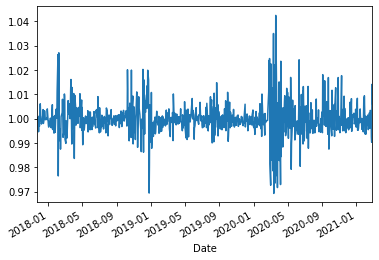

In [1007]:
hist.price1_ratio.plot()

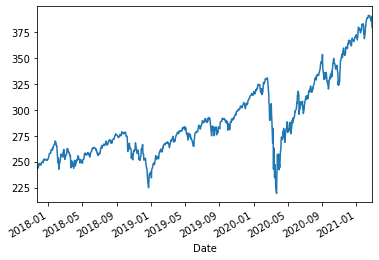

In [1008]:
hist.Close.plot()